# Assignment 2

This set of code contains the answers to the main requirement as well as bonus question 2. To try out our classification algorithm, run your code all the way till the section titled "Test Classifier". Follow the instructions there. Read on to understand the thought process behind the classifier. All data that is needed to run the code below is in the folder. However, you might need to install some libraries to fully run everything.

## Imports and Functions

This section contains the required imports and functions to run the code

In [1]:
import cv2
import os
import numpy as np
from numpy import linalg
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image

In [2]:
# Use this function to parse the json data and take the (x, y) values, and not the confidence score.
# Store all of the data in a (25, 2) array

def extract_keypoints(filePath):
    filename = filePath
    f = open(str(filename),'r')
    content = f.read()
    a = json.loads(content)
    f.close()
    b = a['people']
    data = b[0]['pose_keypoints_2d']
    
    chunks = [data[x:x+2] for x in range(0, len(data), 3)]
        
    return chunks

In [3]:
# Function to obtain the angle between any 2 segments in the stick man figure

def get_angles(vec1, vec2):
    inner = np.inner(vec1, vec2)
    norms = linalg.norm(vec1) * linalg.norm(vec2)

    cos = inner / norms
    rad = np.arccos(np.clip(cos, -1.0, 1.0))
    deg = np.rad2deg(rad)

    return deg

In [4]:
# Function to obtain all the features and store them in a dictionary

def get_dict(arr):
    # Centre all values around point 1 as (0, 0)
    o_x, o_y = arr[1][0], arr[1][1]
    new_arr = []
    for i in range(25):
        new_arr.append([arr[i][0] - o_x, arr[i][1]  - o_y])
        
    # Scale all vectors to body length (Segment 1-8)
    body_len = linalg.norm(new_arr[8])
    new_arr_2 = []
    for i in range(25):
        new_arr_2.append([new_arr[i][0]/body_len, -new_arr[i][1]/body_len])
        
    points = np.array(new_arr_2)
    
    # Get coordinates of important points (0-14 only)
    coord = {}
    coord['x_0'] = points[0][0]
    coord['y_0'] = points[0][1]
    coord['x_1'] = points[1][0]
    coord['y_1'] = points[1][1]
    coord['x_2'] = points[2][0]
    coord['y_2'] = points[2][1]
    coord['x_3'] = points[3][0]
    coord['y_3'] = points[3][1]
    coord['x_4'] = points[4][0]
    coord['y_4'] = points[4][1]
    coord['x_5'] = points[5][0]
    coord['y_5'] = points[5][1]
    coord['x_6'] = points[6][0]
    coord['y_6'] = points[6][1]
    coord['x_7'] = points[7][0]
    coord['y_7'] = points[7][1]
    coord['x_8'] = points[8][0]
    coord['y_8'] = points[8][1]
    coord['x_9'] = points[9][0]
    coord['y_9'] = points[9][1]
    coord['x_10'] = points[10][0]
    coord['y_10'] = points[10][1]
    coord['x_11'] = points[11][0]
    coord['y_11'] = points[11][1]
    coord['x_12'] = points[12][0]
    coord['y_12'] = points[12][1]
    coord['x_13'] = points[13][0]
    coord['y_13'] = points[13][1]
    coord['x_14'] = points[14][0]
    coord['y_14'] = points[14][1]
    
    # Get vectors of each important segment (vector direction points to ground as convention)
    vec = {}
    vec['NK'] = points[1] - points[0]
    vec['LS'] = points[2] - points[1]
    vec['RS'] = points[5] - points[1]
    vec['LA'] = points[3] - points[2]
    vec['RA'] = points[6] - points[5]
    vec['LH'] = points[4] - points[3]
    vec['RH'] = points[7] - points[6]
    vec['TS'] = points[8] - points[1]
    vec['LW'] = points[9] - points[8]
    vec['RW'] = points[12] - points[8]
    vec['LL'] = points[10] - points[9]
    vec['RL'] = points[13] - points[12]
    vec['LC'] = points[11] - points[10]
    vec['RC'] = points[14] - points[13]
    
    # Get angles 
    # for getting the angle, vector should point away from the intersection
    # thus, the second argument is negative
    angles = {}
    angles['l_armpit'] = get_angles(vec['LA'], -vec['LS'])
    angles['r_armpit'] = get_angles(vec['RA'], -vec['RS'])
    angles['l_elbow'] = get_angles(vec['LH'], -vec['LA'])
    angles['r_elbow'] = get_angles(vec['RH'], -vec['RA'])
    angles['l_hip'] = get_angles(vec['LL'], -vec['LW'])
    angles['r_hip'] = get_angles(vec['RL'], -vec['RW'])
    angles['l_knee'] = get_angles(vec['LC'], -vec['LL'])
    angles['r_knee'] = get_angles(vec['RC'], -vec['RL'])
    
    # Get lengths of each vector
    length = {}
    length['NK'] = linalg.norm(vec['NK'])
    length['LS'] = linalg.norm(vec['LS'])
    length['RS'] = linalg.norm(vec['RS'])
    length['LA'] = linalg.norm(vec['LA'])
    length['RA'] = linalg.norm(vec['RA'])
    length['LH'] = linalg.norm(vec['LH'])
    length['RH'] = linalg.norm(vec['RH'])
    length['TS'] = linalg.norm(vec['TS'])
    length['LW'] = linalg.norm(vec['LW'])
    length['RW'] = linalg.norm(vec['RW'])
    length['LL'] = linalg.norm(vec['LL'])
    length['RL'] = linalg.norm(vec['RL'])
    length['LC'] = linalg.norm(vec['LC'])
    length['RC'] = linalg.norm(vec['RC'])
    
    # store coordinates, lengths, and angles into same dict. vectors will not be stored
    pose_info = dict(coord)
    pose_info.update(length)
    pose_info.update(angles)
    
    return(pose_info)

In [5]:
def predict_pose(filepath, model):
    arr = extract_keypoints(filepath)
    features_dct = get_dict(arr)
    df = pd.DataFrame([features_dct])
    pred = model.predict(df)[0]
    
    if pred == 0:
        print('Pose Prediction: STANDING')
    elif pred == 1:
        print('Pose Prediction: SITTING')
    else:
        print('Pose Prediction: RUNNING')

## Test Classifier

To test the classifier, store your json file in the folder named 'pose_data/', and then uncomment the code below. Modify the filename in the first argument of the function "predict_pose" and run the block. You will get the prediction.

In [6]:
# loaded_model = pickle.load(open('xgb_model.pkl', "rb"))

# # Modify the file name here
# predict_pose('pose_data/standing_test.json', loaded_model)

## Answer to requirements and Bonus Question 2

The requirement's task was to design a simple algorithm to classify standing and sitting. That is relatively easy for standard positions (just check angle of knee joint). However, doing a simple rule based algorithm may not generalize well to all types of postures. For example, the knee joint angle while sitting will be the same as a standing position if the person stretches out his legs. Thus, designing a classifier that learns from data is much more robust.

In addition, bonus question 2 asks us to describe a design for identifying different dynamical activities, which may have more variations in postured and thus may not be well-predicted by a rule based classifier unless an engineer covers all possible positions, which is too tedious for him. A machine can process all these information much faster and look through different images at hundreds of thousands of times the speed of a human. Thus, our method will work well with all kinds of dynamical activities as long as it is fed in the right data. In this assignment, we use running as the example.

The rest of the code will walk you through how we designed our classifier to learn from data

### Obtaining Training Data

To get sufficient training data (few hundred images), we could not find suitable ones from the web, and we could not possibly take hundreds of images on our own (it will take too much time!). Instead, we took a video of ourselves in standing, sitting and running positions (running was a dynamic video), moving around as the video went on to capture a variety of positions while standing or sitting. You can access the videos in the folder.

Then, we parsed the video and extracted about 400 frames for each pose as our training data.

Below is our code to extract frames from video and store them in a folder

In [7]:
# cam = cv2.VideoCapture("video.mp4")

# currentframe = 0
# count = 0
  
# while(True):
#     ret,frame = cam.read()
  
#     if ret:
#         name = './folder/frame' + str(currentframe) + '.jpg'
        
#         if count%8 == 0:
#             print ('Creating...' + name)
#             cv2.imwrite(name, frame)
#             currentframe += 1
        
#         count += 1
#     else:
#         break

# cam.release()
# cv2.destroyAllWindows()

Then, we ran all the images in the OpenPose software, and obtained the json files. Using the function 'extract_keypoints' (defined in the "Imports and Functions section), we only extracted the 25 (x, y) positions and discarded the rest of the info. We stored it in a (25, 2) array and saved it into another json file that contained all the hundreds of data from each position

In [8]:
# path = './json_file_location'

# combined_jsons = []

# for mainDir, subDir, fileList in os.walk(path):
#     for file in fileList:
#         currentPath = os.path.join(mainDir, file)
#         kp = extract_keypoints(currentPath)
        
#         combined_jsons.append(kp)
    
#     print(len(combined_jsons))

#     textfile = open("output_filename.json", "w")
#     textfile.write(str(combined_jsons))
#     textfile.close()

The json files were then parsed again to obtain the position data of all the samples

In [9]:
standing_files = ['pose_data/jon_standing_combined.json', 'pose_data/mar_standing_combined.json']
sitting_files = ['pose_data/jon_sitting_combined.json', 'pose_data/mar_sitting_combined.json']
running_files = ['pose_data/jon_running_combined.json', 'pose_data/mar_running_combined.json']

standing = []
for file_name in standing_files:
    f = open(file_name)
    data = json.load(f)
    standing.extend(data)
    
sitting = []
for file_name in sitting_files:
    f = open(file_name)
    data = json.load(f)
    sitting.extend(data)
    
running = []
for file_name in running_files:
    f = open(file_name)
    data = json.load(f)
    running.extend(data)

### Feature Extraction

After that, we do some hand-engineered feature extraction. From the image below, we extract only some position data (circled in yellow), some segment lengths (labelled with green names), and some angles (marked in red). These were used as features to be put into a tree-based classifier.

We also designate point 1 as the (0,0) point, as the output of the json is with the top left of the image as the (0,0) point, but people may be at different locations in the image.

Lastly, we normalize all the vector lengths of each segment with the 1-8 segment (that represents the body) as the unit vector refrence. This is because the size of the person in every image is different.

The code for deriving all these features can be seen in the function 'get_dict' in the section 'Imports and Functions'.

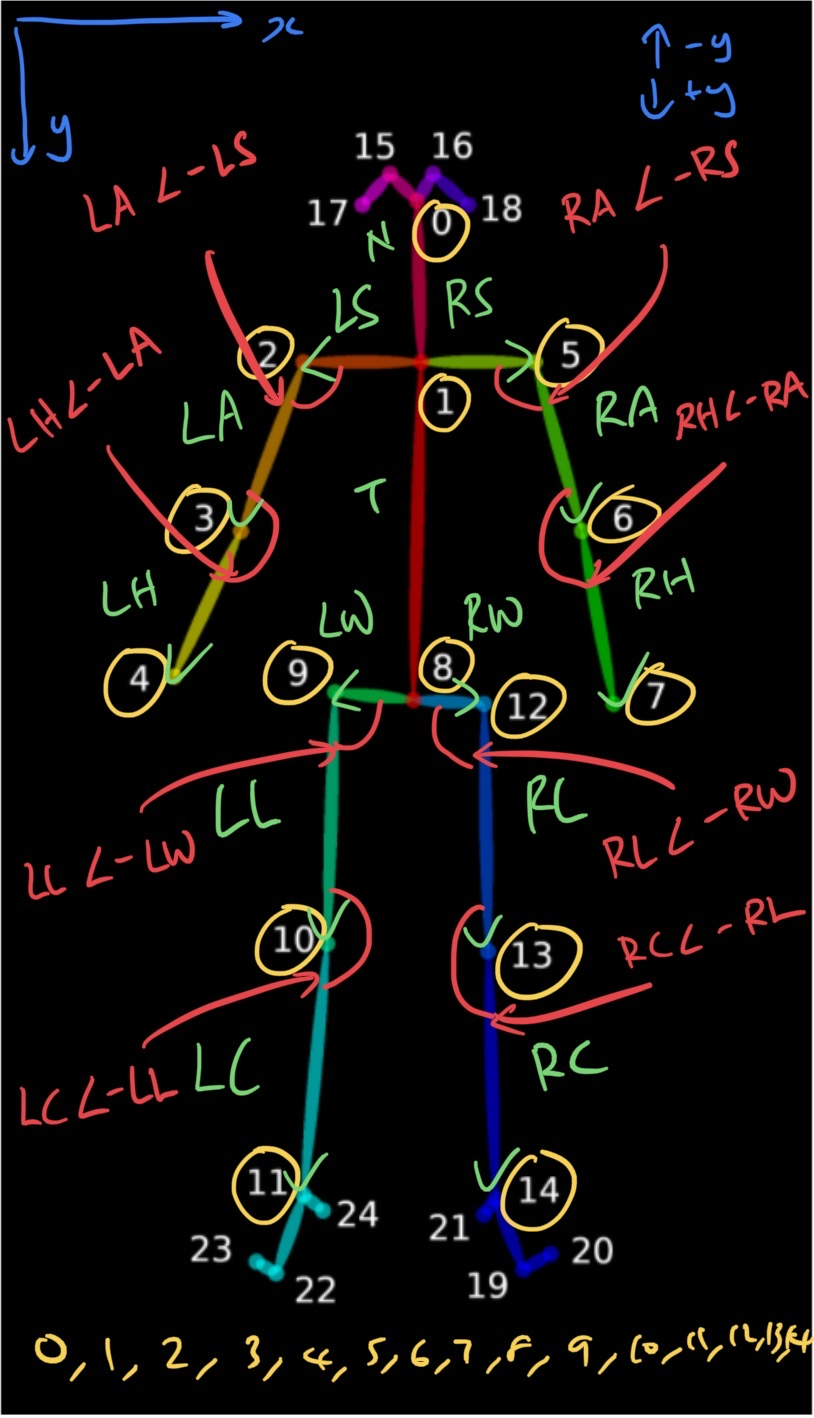

In [10]:
Image(filename='feature_extraction.png', width = 400, height = 200) 

In [11]:
stand_dct_arr = []
for arr in standing:
    stand_dct_arr.append(get_dict(arr))

<ipython-input-3-80b5054ac335>:7: RuntimeWarning: invalid value encountered in double_scalars
  cos = inner / norms


In [12]:
sit_dct_arr = []
for arr in sitting:
    sit_dct_arr.append(get_dict(arr))

<ipython-input-3-80b5054ac335>:7: RuntimeWarning: invalid value encountered in double_scalars
  cos = inner / norms


In [13]:
run_dct_arr = []
for arr in running:
    run_dct_arr.append(get_dict(arr))

<ipython-input-3-80b5054ac335>:7: RuntimeWarning: invalid value encountered in double_scalars
  cos = inner / norms


In [14]:
# Example of dict with all the features
stand_dct_arr[0]

{'x_0': -0.1837094452801963,
 'y_0': 0.3463803026902534,
 'x_1': 0.0,
 'y_1': -0.0,
 'x_2': -0.31410529023760514,
 'y_2': -0.08692780775970407,
 'x_3': -0.37834324964502464,
 'y_3': -0.6280121812182814,
 'x_4': -0.44335000617304254,
 'y_4': -1.0504847989174393,
 'x_5': 0.3462480365189676,
 'y_5': 0.12961051456539965,
 'x_6': 0.3792195130297924,
 'y_6': -0.11946735255492401,
 'x_7': 0.1517878315039517,
 'y_7': 0.32451091793172576,
 'x_8': 0.08695467432574633,
 'y_8': -0.9962122688528301,
 'x_9': -0.1187915550860109,
 'y_9': -1.0175691221976255,
 'x_10': -0.08648140943161467,
 'y_10': -1.8510836670743562,
 'x_11': -0.03251474488810397,
 'y_11': -2.5766462829337278,
 'x_12': 0.30343513020091256,
 'y_12': -0.9853106430163878,
 'x_13': 0.2380377751358164,
 'y_13': -1.840213041121809,
 'x_14': 0.1624042584085593,
 'y_14': -2.695293171894895,
 'NK': 0.39208222910117846,
 'LS': 0.32591191619386706,
 'RS': 0.36971149330139574,
 'LA': 0.544884221307509,
 'RA': 0.25125067592449074,
 'LH': 0.42744

### Preparing the Dataset

All the data is then stored in a pandas dataframe, and target labels are added to standing, sitting, and running as 0, 1, and 2 respectively

In [15]:
stand_df = pd.DataFrame(stand_dct_arr)
stand_df = stand_df.dropna()
stand_df

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0   -0.183709  0.346380  0.0 -0.0 -0.314105 -0.086928 -0.378343 -0.628012   
1   -0.025422  0.505313  0.0 -0.0 -0.378879  0.013218 -0.593423 -0.441762   
2   -0.049400  0.517364  0.0 -0.0 -0.369886  0.000019 -0.469002 -0.506014   
3   -0.036125  0.512160  0.0 -0.0 -0.353960 -0.011563 -0.427417 -0.523862   
4   -0.024133  0.517029  0.0 -0.0 -0.361127  0.011438 -0.481745 -0.518160   
..        ...       ...  ...  ...       ...       ...       ...       ...   
461  0.040596  0.458600  0.0 -0.0 -0.310575  0.053336 -0.445284 -0.500167   
462  0.015250  0.491290  0.0 -0.0 -0.336349  0.055851 -0.476772 -0.520139   
463  0.026973  0.457308  0.0 -0.0 -0.318894  0.041101 -0.458229 -0.512798   
464 -0.012853  0.422419  0.0 -0.0 -0.294640  0.025460 -0.396860 -0.486243   
465 -0.028560  0.428692  0.0 -0.0 -0.286155 -0.013703 -0.343070 -0.528713   

          x_4       y_4  ...        LC        RC    l_armpit    r_armpit  \
0   -0.443350 -1.050485  ...  0.727567  0.858419  112.239796   77.018333   
1   -0.580634 -0.631328  ...  0.969731  0.912768  113.247898  142.231175   
2   -0.481021 -0.925385  ...  0.950477  0.887759  101.079186  134.646954   
3   -0.439108 -1.011578  ...  0.892525  0.853524  100.030888  138.370963   
4   -0.432970 -0.999273  ...  0.882516  0.795715  101.016394  108.632674   
..        ...       ...  ...       ...       ...         ...         ...   
461 -0.526545 -0.999664  ...  0.994759  0.887395   93.933965  100.695290   
462 -0.617840 -1.012106  ...  1.040471  0.833833   94.273087   98.124408   
463 -0.596492 -1.011735  ...  0.574774  0.849144   96.775930   97.896199   
464 -0.511893 -0.908545  ...  0.533407  0.771199   96.358347  100.826066   
465 -0.386540 -0.971149  ...  0.717564  0.744202   99.047835   96.224336   

        l_elbow     r_elbow      l_hip       r_hip      l_knee      r_knee  
0    178.022894   19.583543  93.706301   82.742679  177.966114  179.319659  
1    150.894286   55.816986  84.952528   87.663483  170.061384  177.700428  
2    170.559460   62.727310  90.025760   86.790095  178.521428  176.781745  
3    173.213321   63.851978  90.019466   91.487945  176.097452  179.319160  
4    161.380675  177.964671  89.901524  100.674201  177.716787  166.665374  
..          ...         ...        ...         ...         ...         ...  
461  175.561781  172.861905  76.746939   90.188280  178.558002  175.171448  
462  177.701277  171.130049  78.114888   92.634456  170.784467  179.149464  
463  178.631103  166.061051  90.747543   91.588491  176.391243  179.660899  
464  176.059629  174.228933  89.138134   88.475368  146.853084  179.429585  
465  179.305121  177.780496  96.608031   87.788749  179.052741  178.951520  

[453 rows x 52 columns]

In [16]:
stand_df['target'] = [0] * 453
stand_df.head()

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0 -0.183709  0.346380  0.0 -0.0 -0.314105 -0.086928 -0.378343 -0.628012   
1 -0.025422  0.505313  0.0 -0.0 -0.378879  0.013218 -0.593423 -0.441762   
2 -0.049400  0.517364  0.0 -0.0 -0.369886  0.000019 -0.469002 -0.506014   
3 -0.036125  0.512160  0.0 -0.0 -0.353960 -0.011563 -0.427417 -0.523862   
4 -0.024133  0.517029  0.0 -0.0 -0.361127  0.011438 -0.481745 -0.518160   

        x_4       y_4  ...        RC    l_armpit    r_armpit     l_elbow  \
0 -0.443350 -1.050485  ...  0.858419  112.239796   77.018333  178.022894   
1 -0.580634 -0.631328  ...  0.912768  113.247898  142.231175  150.894286   
2 -0.481021 -0.925385  ...  0.887759  101.079186  134.646954  170.559460   
3 -0.439108 -1.011578  ...  0.853524  100.030888  138.370963  173.213321   
4 -0.432970 -0.999273  ...  0.795715  101.016394  108.632674  161.380675   

      r_elbow      l_hip       r_hip      l_knee      r_knee  target  
0   19.583543  93.706301   82.742679  177.966114  179.319659       0  
1   55.816986  84.952528   87.663483  170.061384  177.700428       0  
2   62.727310  90.025760   86.790095  178.521428  176.781745       0  
3   63.851978  90.019466   91.487945  176.097452  179.319160       0  
4  177.964671  89.901524  100.674201  177.716787  166.665374       0  

[5 rows x 53 columns]

In [17]:
sit_df = pd.DataFrame(sit_dct_arr)
sit_df = sit_df.dropna()
sit_df

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0    0.219951  0.342563  0.0 -0.0 -0.708952 -0.048927 -1.026964 -0.892872   
1   -0.045423  0.331917  0.0 -0.0 -0.331672 -0.000013 -0.754849  0.503134   
2   -0.080596  0.391030  0.0 -0.0 -0.390665  0.000054 -0.983184  0.498286   
3   -0.088731  0.396113  0.0 -0.0 -0.370130 -0.012677 -0.958109  0.357785   
4   -0.050758  0.366770  0.0 -0.0 -0.354256 -0.012866 -0.557020 -0.379882   
..        ...       ...  ...  ...       ...       ...       ...       ...   
500 -0.289737  0.385407  0.0 -0.0 -0.144809  0.016292 -0.289756 -0.402404   
501 -0.277848  0.391927  0.0 -0.0 -0.147479  0.016501 -0.425033 -0.326893   
502 -0.300105  0.398948  0.0 -0.0 -0.200151  0.016738 -0.366597 -0.149671   
503 -0.215796  0.398811  0.0 -0.0 -0.315730 -0.016519 -0.614403 -0.233081   
504 -0.062945  0.509267  0.0 -0.0 -0.403328  0.020426 -0.360260 -0.617540   

          x_4       y_4  ...        LC        RC    l_armpit    r_armpit  \
0   -1.370601  1.835266  ...  1.278610  1.370246  114.595134   67.141314   
1   -0.308826  0.377513  ...  1.204899  1.502324  130.063595  140.314555   
2   -0.431392  0.418354  ...  1.458792  1.797478  139.948424  133.722054   
3   -0.587076  0.408234  ...  1.698763  1.684992  145.825020  137.142393   
4   -0.505848  0.164516  ...  1.517835  1.678470  120.999055  132.521871   
..        ...       ...  ...       ...       ...         ...         ...   
500 -0.338042 -0.144777  ...  1.095675  1.088179  102.675901   85.832140   
501 -0.327474 -0.098435  ...  1.128995  1.124734  122.563269   85.295702   
502 -0.449537 -0.199741  ...  1.148418  1.158580  130.226324   83.008743   
503 -0.614764 -0.381536  ...  1.131537  1.152005  147.049881  111.358956   
504  0.191558 -0.956887  ...  1.168988  1.151034   83.238815   86.463693   

        l_elbow     r_elbow       l_hip       r_hip      l_knee      r_knee  
0     27.826423   98.048635   96.109519  142.629756  173.190309  129.214886  
1     34.204473   40.633161  111.176347  105.962015   32.725681  163.667074  
2     31.817046   40.758956  130.002385  123.027154    8.215367  142.042313  
3     39.956353   38.699096  163.055533  128.250983   66.172845  132.124303  
4     23.549285   41.555510  150.588154  126.208226  108.883842  134.600482  
..          ...         ...         ...         ...         ...         ...  
500   29.710792  146.596849   30.859488   46.815152  118.273530   77.341690  
501   15.823310  146.453493   30.343774   45.341712  114.125742   76.738863  
502  166.125482  133.164966   35.731266   45.084722  119.542635   79.997495  
503  126.084664   55.531343   32.281174   44.456564  115.658667   85.284881  
504  125.452027  119.303723   88.615455  127.773839  178.246241  142.707655  

[495 rows x 52 columns]

In [18]:
sit_df['target'] = [1] * 495
sit_df.head()

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0  0.219951  0.342563  0.0 -0.0 -0.708952 -0.048927 -1.026964 -0.892872   
1 -0.045423  0.331917  0.0 -0.0 -0.331672 -0.000013 -0.754849  0.503134   
2 -0.080596  0.391030  0.0 -0.0 -0.390665  0.000054 -0.983184  0.498286   
3 -0.088731  0.396113  0.0 -0.0 -0.370130 -0.012677 -0.958109  0.357785   
4 -0.050758  0.366770  0.0 -0.0 -0.354256 -0.012866 -0.557020 -0.379882   

        x_4       y_4  ...        RC    l_armpit    r_armpit    l_elbow  \
0 -1.370601  1.835266  ...  1.370246  114.595134   67.141314  27.826423   
1 -0.308826  0.377513  ...  1.502324  130.063595  140.314555  34.204473   
2 -0.431392  0.418354  ...  1.797478  139.948424  133.722054  31.817046   
3 -0.587076  0.408234  ...  1.684992  145.825020  137.142393  39.956353   
4 -0.505848  0.164516  ...  1.678470  120.999055  132.521871  23.549285   

     r_elbow       l_hip       r_hip      l_knee      r_knee  target  
0  98.048635   96.109519  142.629756  173.190309  129.214886       1  
1  40.633161  111.176347  105.962015   32.725681  163.667074       1  
2  40.758956  130.002385  123.027154    8.215367  142.042313       1  
3  38.699096  163.055533  128.250983   66.172845  132.124303       1  
4  41.555510  150.588154  126.208226  108.883842  134.600482       1  

[5 rows x 53 columns]

In [19]:
run_df = pd.DataFrame(run_dct_arr)
run_df = run_df.dropna()
run_df

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0   -0.277388  0.232990  0.0 -0.0 -0.066653 -0.066158  0.088347 -0.520460   
1    0.328110  0.294881  0.0 -0.0 -0.113166  0.158679 -0.373458 -0.351048   
2    0.253369  0.345220  0.0 -0.0 -0.103737  0.137999 -0.645056 -0.138760   
3    0.316359  0.327791  0.0 -0.0 -0.090707  0.170006 -0.711980  0.079096   
4    0.243578  0.334667  0.0 -0.0 -0.080693  0.090982 -0.384889 -0.395774   
..        ...       ...  ...  ...       ...       ...       ...       ...   
414  0.119993  0.462745  0.0 -0.0 -0.254262  0.059789 -0.642215 -0.358024   
415  0.158937  0.433746  0.0 -0.0 -0.202272  0.028550 -0.448883 -0.478158   
416  0.133649  0.478454  0.0 -0.0 -0.165275  0.015505 -0.253992 -0.611572   
417  0.101216  0.420089  0.0 -0.0 -0.202718  0.028705 -0.144815 -0.463095   
418 -0.156719  0.454107  0.0 -0.0 -0.203625 -0.015650 -0.203253 -0.515271   

          x_4       y_4  ...        LC        RC    l_armpit    r_armpit  \
0   -0.166316 -0.664824  ...  0.706096  0.838168  115.947685   82.044855   
1    0.180880 -0.599650  ...  1.007400  0.629866   62.546707  131.396570   
2   -0.910171 -0.680311  ...  0.988307  0.869468   99.853790  174.915239   
3   -0.813631 -0.485561  ...  0.947138  0.854427  109.757347  155.417569   
4    0.061237 -0.628728  ...  0.863176  0.716871   73.573256  118.688245   
..        ...       ...  ...       ...       ...         ...         ...   
414 -0.642318 -0.880520  ...  0.957686  0.803095  119.645123  105.482227   
415 -0.405398 -1.012563  ...  0.889999  0.787107  107.917684  102.161621   
416  0.313329 -0.701556  ...  0.873719  0.888338   92.693183  101.601355   
417  0.361340 -0.188214  ...  0.863515  0.940065   75.225512  105.909419   
418 -1.971885  1.768716  ...  0.847256  0.948689   94.352422   94.609921   

        l_elbow     r_elbow       l_hip       r_hip      l_knee      r_knee  
0    100.709271   76.418635  163.855238  104.809732  140.236550  125.693986  
1     87.103535   60.566151   45.244641  107.195135  109.508164  173.076463  
2    143.163139   76.162268    8.823303  120.567532   78.488082  143.597606  
3    108.530087   62.741596   23.249010  122.168765  114.256369  142.138682  
4     85.569109  115.723872   72.593320  141.353540  147.058243   70.764301  
..          ...         ...         ...         ...         ...         ...  
414  137.133574   38.664305   20.304077   93.736127  105.846902  173.041901  
415  149.396337   25.801372   66.585721  133.414467  154.689573   96.502203  
416   90.960080   89.943309   91.899274  171.218232  154.615526   68.078942  
417   68.209611  173.050692   90.833092  143.376575  157.115286  111.082919  
418   37.710187   88.652415  101.900749   48.679755  162.773859  105.703093  

[373 rows x 52 columns]

In [20]:
run_df['target'] = [2] * 373
run_df.head()

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0 -0.277388  0.232990  0.0 -0.0 -0.066653 -0.066158  0.088347 -0.520460   
1  0.328110  0.294881  0.0 -0.0 -0.113166  0.158679 -0.373458 -0.351048   
2  0.253369  0.345220  0.0 -0.0 -0.103737  0.137999 -0.645056 -0.138760   
3  0.316359  0.327791  0.0 -0.0 -0.090707  0.170006 -0.711980  0.079096   
4  0.243578  0.334667  0.0 -0.0 -0.080693  0.090982 -0.384889 -0.395774   

        x_4       y_4  ...        RC    l_armpit    r_armpit     l_elbow  \
0 -0.166316 -0.664824  ...  0.838168  115.947685   82.044855  100.709271   
1  0.180880 -0.599650  ...  0.629866   62.546707  131.396570   87.103535   
2 -0.910171 -0.680311  ...  0.869468   99.853790  174.915239  143.163139   
3 -0.813631 -0.485561  ...  0.854427  109.757347  155.417569  108.530087   
4  0.061237 -0.628728  ...  0.716871   73.573256  118.688245   85.569109   

      r_elbow       l_hip       r_hip      l_knee      r_knee  target  
0   76.418635  163.855238  104.809732  140.236550  125.693986       2  
1   60.566151   45.244641  107.195135  109.508164  173.076463       2  
2   76.162268    8.823303  120.567532   78.488082  143.597606       2  
3   62.741596   23.249010  122.168765  114.256369  142.138682       2  
4  115.723872   72.593320  141.353540  147.058243   70.764301       2  

[5 rows x 53 columns]

In [21]:
full_df = pd.concat([stand_df, sit_df, run_df], ignore_index=True)
full_df

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
0    -0.183709  0.346380  0.0 -0.0 -0.314105 -0.086928 -0.378343 -0.628012   
1    -0.025422  0.505313  0.0 -0.0 -0.378879  0.013218 -0.593423 -0.441762   
2    -0.049400  0.517364  0.0 -0.0 -0.369886  0.000019 -0.469002 -0.506014   
3    -0.036125  0.512160  0.0 -0.0 -0.353960 -0.011563 -0.427417 -0.523862   
4    -0.024133  0.517029  0.0 -0.0 -0.361127  0.011438 -0.481745 -0.518160   
...        ...       ...  ...  ...       ...       ...       ...       ...   
1316  0.119993  0.462745  0.0 -0.0 -0.254262  0.059789 -0.642215 -0.358024   
1317  0.158937  0.433746  0.0 -0.0 -0.202272  0.028550 -0.448883 -0.478158   
1318  0.133649  0.478454  0.0 -0.0 -0.165275  0.015505 -0.253992 -0.611572   
1319  0.101216  0.420089  0.0 -0.0 -0.202718  0.028705 -0.144815 -0.463095   
1320 -0.156719  0.454107  0.0 -0.0 -0.203625 -0.015650 -0.203253 -0.515271   

           x_4       y_4  ...        RC    l_armpit    r_armpit     l_elbow  \
0    -0.443350 -1.050485  ...  0.858419  112.239796   77.018333  178.022894   
1    -0.580634 -0.631328  ...  0.912768  113.247898  142.231175  150.894286   
2    -0.481021 -0.925385  ...  0.887759  101.079186  134.646954  170.559460   
3    -0.439108 -1.011578  ...  0.853524  100.030888  138.370963  173.213321   
4    -0.432970 -0.999273  ...  0.795715  101.016394  108.632674  161.380675   
...        ...       ...  ...       ...         ...         ...         ...   
1316 -0.642318 -0.880520  ...  0.803095  119.645123  105.482227  137.133574   
1317 -0.405398 -1.012563  ...  0.787107  107.917684  102.161621  149.396337   
1318  0.313329 -0.701556  ...  0.888338   92.693183  101.601355   90.960080   
1319  0.361340 -0.188214  ...  0.940065   75.225512  105.909419   68.209611   
1320 -1.971885  1.768716  ...  0.948689   94.352422   94.609921   37.710187   

         r_elbow       l_hip       r_hip      l_knee      r_knee  target  
0      19.583543   93.706301   82.742679  177.966114  179.319659       0  
1      55.816986   84.952528   87.663483  170.061384  177.700428       0  
2      62.727310   90.025760   86.790095  178.521428  176.781745       0  
3      63.851978   90.019466   91.487945  176.097452  179.319160       0  
4     177.964671   89.901524  100.674201  177.716787  166.665374       0  
...          ...         ...         ...         ...         ...     ...  
1316   38.664305   20.304077   93.736127  105.846902  173.041901       2  
1317   25.801372   66.585721  133.414467  154.689573   96.502203       2  
1318   89.943309   91.899274  171.218232  154.615526   68.078942       2  
1319  173.050692   90.833092  143.376575  157.115286  111.082919       2  
1320   88.652415  101.900749   48.679755  162.773859  105.703093       2  

[1321 rows x 53 columns]

The dataset is split into train and test

In [22]:
train_df, test_df = train_test_split(full_df, test_size=0.2)

In [23]:
train_df.head()

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
727  -0.100027  0.518741  0.0 -0.0 -0.399935  0.019380 -0.678408 -0.419481   
444   0.013587  0.477696  0.0 -0.0 -0.327501  0.040366 -0.410054 -0.506026   
1041  0.278237  0.336143  0.0 -0.0 -0.150832  0.173831 -0.464749 -0.301583   
1143  0.124664  0.428755  0.0 -0.0 -0.166235  0.027169 -0.373640 -0.498931   
679   0.017810  0.490939  0.0 -0.0 -0.377859 -0.018696 -0.566302 -0.565103   

           x_4       y_4  ...        RC    l_armpit    r_armpit     l_elbow  \
727  -0.598626 -0.799303  ...  1.352409  119.622266   84.267459  135.740837   
444  -0.532832 -0.957503  ...  0.808716   91.565199   97.045080  173.378219   
1041  0.057847 -0.580693  ...  0.958312   74.384955  119.790192   84.669106   
1143 -0.152646 -0.983023  ...  0.786008  102.233726  110.211014  133.946925   
679  -0.641557 -0.923466  ...  1.188083  111.860818  131.948526  172.831467   

         r_elbow       l_hip       r_hip      l_knee      r_knee  target  
727    97.534807  171.645696  176.910032   21.365081   13.329287       1  
444   177.990844   87.335248   93.381460  171.869018  179.803005       0  
1041   75.789535   38.350818  108.360803   79.750766  156.140309       2  
1143  110.512042   95.982367  135.769095  155.618699   86.899570       2  
679   138.544110   48.814822   93.639088  132.548186   32.332406       1  

[5 rows x 53 columns]

In [24]:
test_df.head()

x_0       y_0  x_1  y_1       x_2       y_2       x_3       y_3  \
1217 -0.147571  0.474380  0.0 -0.0 -0.179697 -0.033614 -0.261205 -0.574035   
1246 -0.153810  0.491871  0.0 -0.0 -0.169385 -0.046397 -0.169173 -0.600447   
313   0.013836  0.360275  0.0 -0.0 -0.158988  0.000240  0.014320 -0.491097   
261  -1.495177  1.654921  0.0 -0.0  0.346377 -0.000260  0.786139 -0.292943   
495  -0.067015  0.534692  0.0 -0.0 -0.454870 -0.013927 -0.976005 -0.574938   

           x_4       y_4  ...        RC    l_armpit    r_armpit     l_elbow  \
1217 -0.654223 -0.344003  ...  0.859488  109.172082  119.754894   68.236600   
1246 -0.630825 -0.692563  ...  0.848248  105.296659  100.848080  101.262508   
313   0.331655 -0.837391  ...  0.710841   70.484406  104.748882  156.927800   
261   0.359251 -0.519445  ...  0.982968  146.397237  154.773641   61.595604   
495  -0.722015 -0.775767  ...  1.598292  134.643423  110.548312   85.443768   

         r_elbow       l_hip       r_hip      l_knee      r_knee  target  
1217  118.881366  100.132446   41.496163  151.327216  123.724004       2  
1246  145.511434   87.986090   27.321127  167.817617   55.969362       2  
313   178.393536   99.021211   83.601269  153.268116  179.506882       0  
261    60.108277   83.003024   88.412918  176.123386  165.780291       0  
495   116.139885  126.721932  153.391099   15.493170  121.010898       1  

[5 rows x 53 columns]

### Training and Evaluating the Model

A simple XGBoost model is trained with arbitrary hyperparams (from experience)

In [25]:
model = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=100, n_jobs=-1, colsample_bytree=0.2)
model.fit(train_df.drop('target', axis=1), train_df['target'])

/Users/jonathanchua/anaconda3/envs/pyenv3.7/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:39:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
train_pred = model.predict(train_df.drop('target', axis=1))
test_pred = model.predict(test_df.drop('target', axis=1))

Due to the stark difference in standing, sitting, and running, the train accuracy is 100%, while the test accuracy is close to that at 99%

In [27]:
# Train accuracy
accuracy_score(train_df['target'].to_numpy(), train_pred)

1.0

In [28]:
# Test accuracy
accuracy_score(test_df['target'].to_numpy(), test_pred)

0.9962264150943396

The figure below displays the feature importances of identifying the positions. As you can see, almost all features are somewhat taken into consideration, although there are some more important than others

<BarContainer object of 52 artists>

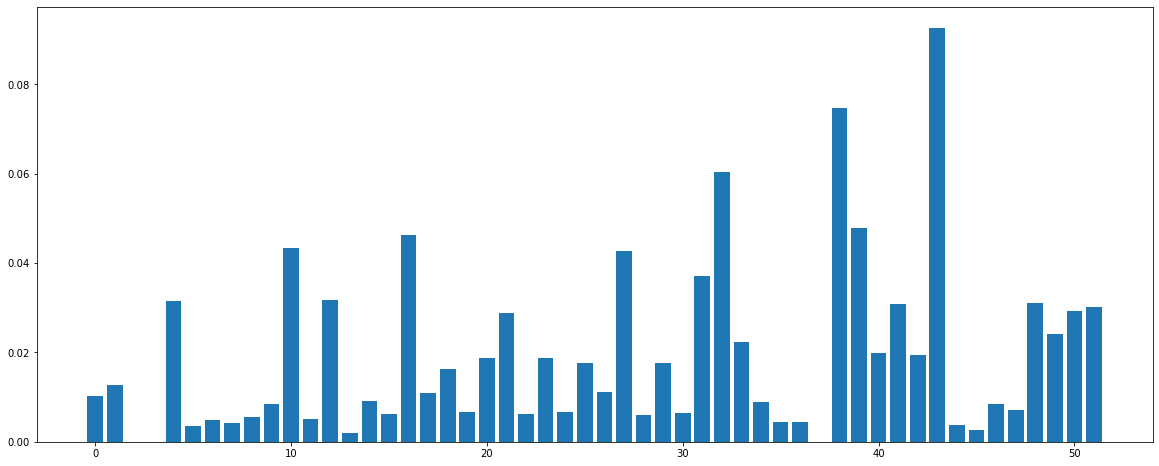

In [29]:
plt.figure(figsize=(20, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

### Save and load the model

In [30]:
file_name = "xgb_model.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

In [31]:
# load
loaded_model = pickle.load(open(file_name, "rb"))

### Testing on Out of Sample Data

The following images of standing, sitting, and running were taken in a different location and not part of the train or test set. We will use them to evaluate the model.

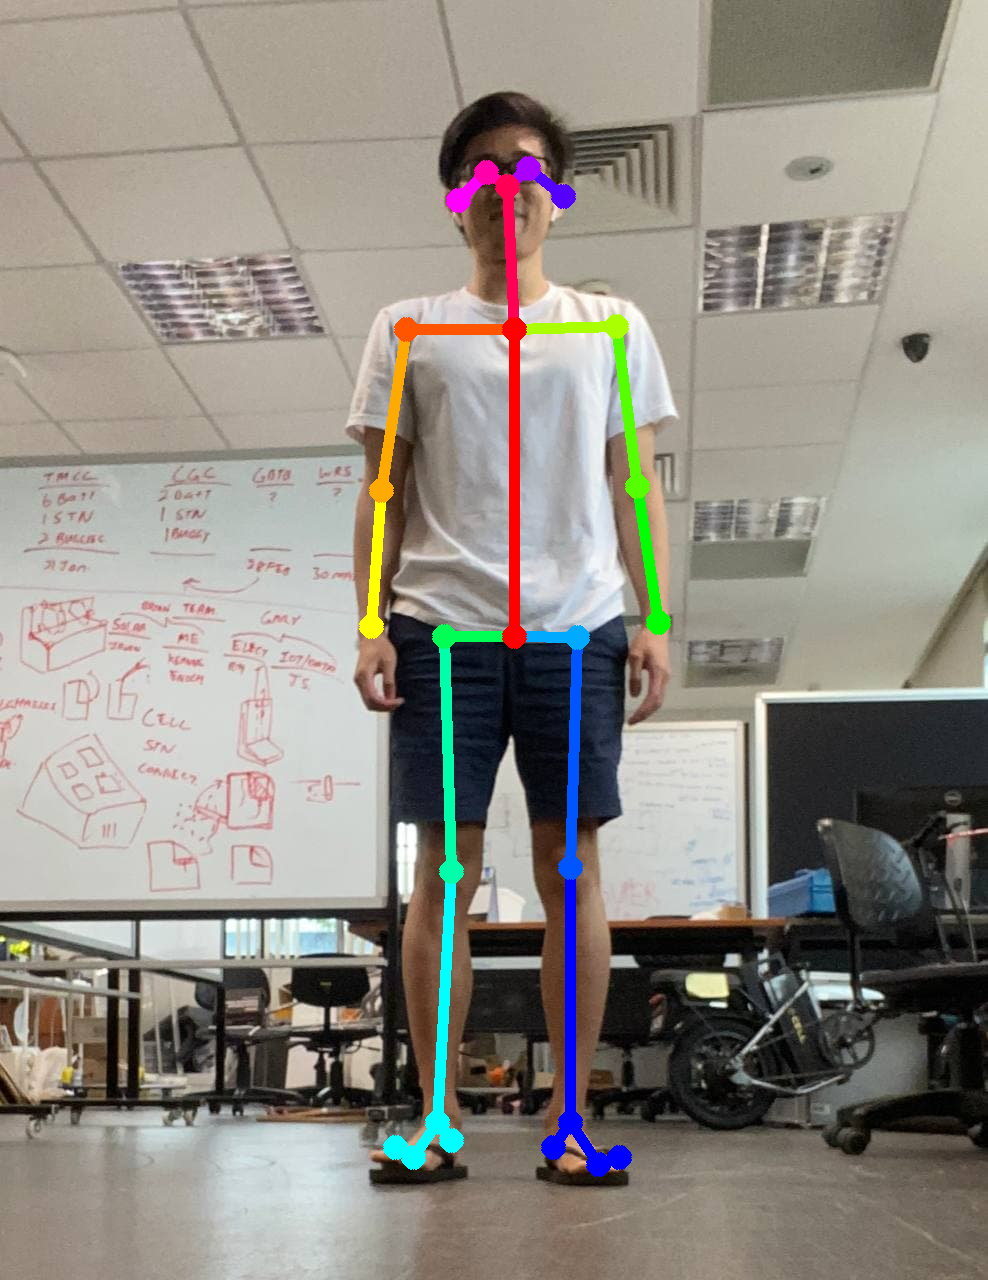

In [32]:
Image(filename='pose_data/standing_test.png', width = 300, height = 150) 

In [40]:
# Json data output
f = open(str('pose_data/standing_test.json'),'r')
content = f.read()
print(json.loads(content))

{'version': 1.3, 'people': [{'person_id': [-1], 'pose_keypoints_2d': [507.29, 185.765, 0.913663, 514.165, 329.035, 0.94354, 405.902, 329.035, 0.867959, 381.301, 489.714, 0.934189, 371.018, 626.133, 0.928256, 615.611, 325.568, 0.870066, 636.504, 486.109, 0.906876, 657.511, 622.448, 0.930173, 514.082, 636.49, 0.739204, 444.366, 636.435, 0.685516, 451.357, 870.558, 0.838659, 437.328, 1122.24, 0.850736, 577.228, 636.563, 0.722389, 570.213, 867.188, 0.843268, 570.145, 1122.3, 0.838889, 486.201, 171.759, 0.956756, 528.202, 168.273, 0.909662, 458.142, 199.775, 0.958326, 563.127, 196.159, 0.933684, 598.14, 1164.32, 0.754336, 618.984, 1157.17, 0.850252, 552.727, 1146.73, 0.78139, 412.889, 1157.2, 0.751119, 395.294, 1146.73, 0.750879, 451.293, 1139.83, 0.827894], 'face_keypoints_2d': [], 'hand_left_keypoints_2d': [], 'hand_right_keypoints_2d': [], 'pose_keypoints_3d': [], 'face_keypoints_3d': [], 'hand_left_keypoints_3d': [], 'hand_right_keypoints_3d': []}]}


In [33]:
predict_pose('pose_data/standing_test.json', loaded_model)

Pose Prediction: STANDING


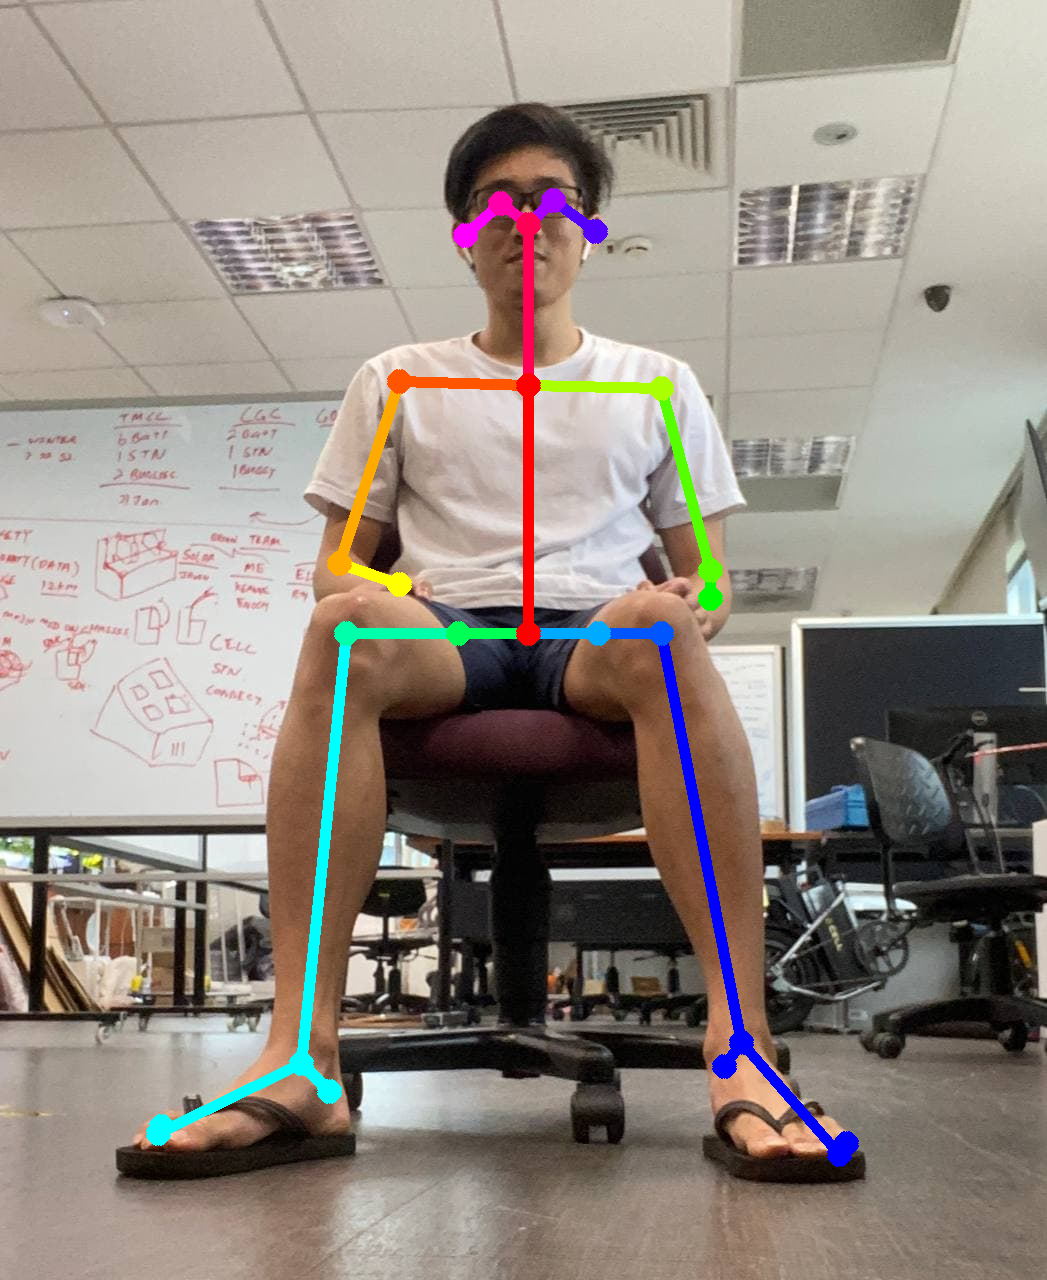

In [34]:
Image(filename='pose_data/sitting_test.png', width = 300, height = 150) 

In [41]:
# Json data output
f = open(str('pose_data/sitting_test.json'),'r')
content = f.read()
print(json.loads(content))

{'version': 1.3, 'people': [{'person_id': [-1], 'pose_keypoints_2d': [528.129, 224.146, 0.899704, 528.227, 384.891, 0.875981, 398.802, 381.476, 0.825535, 339.442, 563.087, 0.837085, 398.831, 583.999, 0.754884, 661.05, 388.438, 0.812854, 709.903, 570.022, 0.855837, 709.852, 598.047, 0.808302, 528.231, 632.989, 0.690851, 458.309, 632.955, 0.661017, 346.433, 633.084, 0.837191, 301.074, 1062.88, 0.697597, 598.076, 632.97, 0.650605, 661.083, 633.003, 0.80519, 741.361, 1041.88, 0.706522, 500.236, 203.183, 0.932224, 552.735, 199.726, 0.926887, 465.246, 234.665, 0.933074, 594.518, 231.129, 0.92563, 839.197, 1153.75, 0.571976, 846.149, 1143.25, 0.631755, 723.892, 1066.37, 0.45429, 157.773, 1132.79, 0.566524, 161.203, 1125.7, 0.497855, 328.958, 1090.8, 0.606087], 'face_keypoints_2d': [], 'hand_left_keypoints_2d': [], 'hand_right_keypoints_2d': [], 'pose_keypoints_3d': [], 'face_keypoints_3d': [], 'hand_left_keypoints_3d': [], 'hand_right_keypoints_3d': []}]}


In [35]:
predict_pose('pose_data/sitting_test.json', loaded_model)

Pose Prediction: SITTING


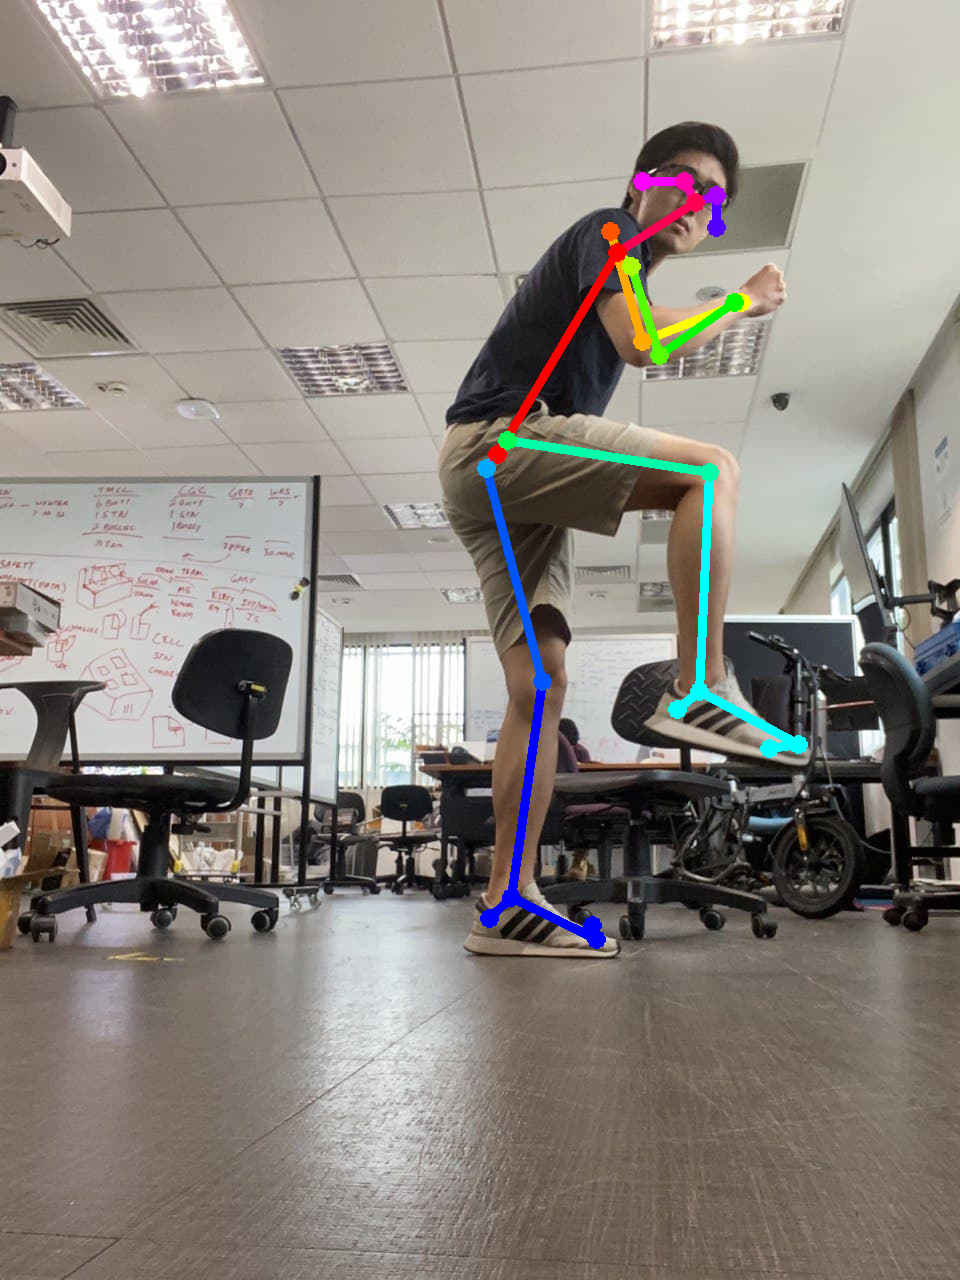

In [36]:
Image(filename='pose_data/running_test.png', width = 300, height = 150) 

In [42]:
# Json data output
f = open(str('pose_data/running_test.json'),'r')
content = f.read()
print(json.loads(content))

{'version': 1.3, 'people': [{'person_id': [-1], 'pose_keypoints_2d': [694.902, 202.426, 0.934066, 617.01, 252.019, 0.782713, 609.87, 230.702, 0.894695, 641.865, 340.523, 0.921219, 740.954, 301.584, 0.926346, 631.1, 266.238, 0.61082, 659.4, 354.75, 0.0985004, 733.938, 301.624, 0.0711692, 496.586, 453.938, 0.678979, 507.052, 439.892, 0.69615, 709.166, 471.625, 0.906916, 698.531, 691.376, 0.825152, 485.873, 468.155, 0.509091, 542.476, 680.834, 0.848968, 510.634, 896.85, 0.816288, 684.322, 181.065, 0.956332, 716.076, 195.389, 0.956389, 641.719, 181.182, 0.96712, 716.194, 227.149, 0.284829, 595.747, 939.329, 0.693378, 592.104, 925.274, 0.652497, 489.362, 918.196, 0.766695, 797.604, 744.421, 0.660311, 769.288, 748.045, 0.620069, 677.195, 709.094, 0.705171], 'face_keypoints_2d': [], 'hand_left_keypoints_2d': [], 'hand_right_keypoints_2d': [], 'pose_keypoints_3d': [], 'face_keypoints_3d': [], 'hand_left_keypoints_3d': [], 'hand_right_keypoints_3d': []}]}


In [37]:
predict_pose('pose_data/running_test.json', loaded_model)

Pose Prediction: RUNNING


### Other dynamic poses

This pipeline gives us a good method to evaluate other dynamic poses like falling or walking, as long as we have sufficient data for them. Running in this case was used as the example and it works well as tested above.